# MadMiner : Queue of Miners 

This a large queue of miners, used to quickly perform the mining from the MadGraph mine. 

## 0. Setup Environment

In [1]:
#Set right path to MadMiner
import sys
import os
delphes_src_path = "/Users/felixkling/Documents/GitHub/delphesminer"
sys.path.append(delphes_src_path)
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

#Import MadMiner
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.tools.plots import plot_2d_morphing_basis
from delphesprocessor.delphesprocessor import DelphesProcessor

#Set Path to MG5 directory
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Define parameter space

In [2]:
#Initialize GoldMiner
miner = GoldMine()

#Define Parameter Space
miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)

08:41  
08:41  ------------------------------------------------------------
08:41  |                                                          |
08:41  |  MadMiner                                                |
08:41  |                                                          |
08:41  |  Version from July 19, 2018                              |
08:41  |                                                          |
08:41  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
08:41  |                                                          |
08:41  ------------------------------------------------------------
08:41  
08:41  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
08:41  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))


## 2. Define benchmark points (evaluation points for |M|^2)

I now define all benchmarks by hand - to be able to regenerate more events with same benchmarks later

08:41  Added benchmark bsm0: CWL2 = -4.00e+00, CPWL2 = 0.00e+00)
08:41  Added benchmark bsm1: CWL2 = 4.00, CPWL2 = 0.00e+00)
08:41  Added benchmark bsm2: CWL2 = 2.77, CPWL2 = 8.62)
08:41  Added benchmark bsm3: CWL2 = 1.47, CPWL2 = -8.21e+00)
08:41  Added benchmark bsm4: CWL2 = -5.71e+00, CPWL2 = -7.29e+00)
08:41  Added benchmark bsm5: CWL2 = 7.55, CPWL2 = -9.31e+00)
08:41  Optimizing basis for morphing
08:41  Added benchmark bsm0: CWL2 = -4.00e+00, CPWL2 = 0.00e+00)
08:41  Added benchmark bsm1: CWL2 = 4.00, CPWL2 = 0.00e+00)
08:41  Added benchmark bsm2: CWL2 = 2.77, CPWL2 = 8.62)
08:41  Added benchmark bsm3: CWL2 = 1.47, CPWL2 = -8.21e+00)
08:41  Added benchmark bsm4: CWL2 = -5.71e+00, CPWL2 = -7.29e+00)
08:41  Added benchmark bsm5: CWL2 = 7.55, CPWL2 = -9.31e+00)
08:41  Saving setup (including morphing) to data/madminer_example.h5


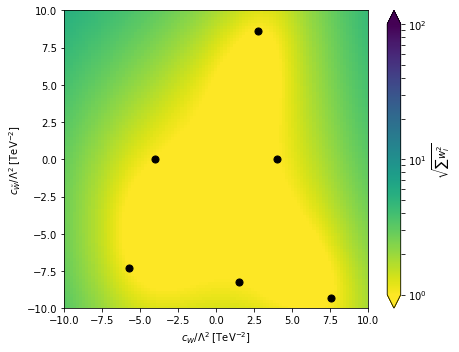

In [3]:
#Add Benchmark by hand
miner.add_benchmark(
    {'CWL2':-4., 'CPWL2':0.},
    'bsm0'
)
miner.add_benchmark(
    {'CWL2':4., 'CPWL2':0.},
    'bsm1'
)
miner.add_benchmark(
    {'CWL2':2.77, 'CPWL2':8.62},
    'bsm2'
)
miner.add_benchmark(
    {'CWL2':1.47, 'CPWL2':-8.21},
    'bsm3'
)
miner.add_benchmark(
    {'CWL2':-5.71, 'CPWL2':-7.29},
    'bsm4'
)
miner.add_benchmark(
    {'CWL2':7.55, 'CPWL2':-9.31},
    'bsm5'
)

#Set Benchmarks
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

#Plot Benchmarks
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-10.,10),
    yrange=(-10.,10.)
)

#Save Settings
miner.save('data/madminer_example.h5')

## 3. Save settings and run MadGraph + Delphes

Run everything

In [4]:
#Set number of runs
nruns = 5

#Loop
for counter in range (1, nruns+1):
    #remove old MG_process / not sure if necessary but why not
    ! rm -rf /Users/felixkling/Documents/GitHub/madminer/examples/usage/MG_process
    
    #Run MG5/Reweight/Pythia
    miner.run(mg_directory=mg_dir,
              proc_card_file='cards/proc_card.dat',
              param_card_template_file='cards/param_card_template.dat',
              reweight_card_template_file='cards/reweight_card_template.dat',
              run_card_file='cards/run_card.dat',
              pythia8_card_file='cards/pythia8_card.dat',
              sample_benchmark='bsm0',
              initial_command='source ~/.bashrc'
              )
    
    #Initialize DelphesProcessor
    dm = DelphesProcessor()
    
    #Set hepmc file 
    dm.add_hepmc_sample('MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz')
    
    #Run Delphes
    dm.run_delphes(delphes_directory=mg_dir + '/Delphes',
               delphes_card='cards/delphes_card.dat',
               initial_command='source ~/.bashrc')
    
    #Define observables 
    dm.add_observable('pt_e1', 'e[0].pt', required=True)
    dm.add_observable('pt_mu1', 'mu[0].pt', required=True)
    dm.add_observable('delta_eta_ll', 'abs(e[0].eta - mu[0].eta)', required=True)
    dm.add_observable('delta_phi_ll', 'abs(e[0].phi() - mu[0].phi())', required=True)
    
    #Extract all these observables from the Delphes ROOT file generated before:
    dm.analyse_delphes_samples()
    
    #The values of the observables and the weights are then saved in the HDF5 file
    dm.save('data/madminer_example_with_data_run'+`counter`+'.h5', 'data/madminer_example.h5')

08:41  Generating MadGraph process folder from cards/proc_card.dat at ./MG_process
08:41  Creating param and reweight cards in ./MG_process
08:41  Starting MadGraph and Pythia in ./MG_process
08:55  
08:55  ------------------------------------------------------------
08:55  |                                                          |
08:55  |  DelphesProcessor                                        |
08:55  |                                                          |
08:55  |  Version from July 19, 2018                              |
08:55  |                                                          |
08:55  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
08:55  |                                                          |
08:55  ------------------------------------------------------------
08:55  
08:55  Hi! How are you today?
08:55  Adding HepMC sample at MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz
08:55  Running Delphes at /Users/felixkling/work/MG5_aMC_v2_6_2/D

10:04  Running Delphes at /Users/felixkling/work/MG5_aMC_v2_6_2/Delphes
10:06  Adding required observable pt_e1 = e[0].pt
10:06  Adding required observable pt_mu1 = mu[0].pt
10:06  Adding required observable delta_eta_ll = abs(e[0].eta - mu[0].eta)
10:06  Adding required observable delta_phi_ll = abs(e[0].phi() - mu[0].phi())
10:06  Analysing Delphes sample MG_process/Events/run_01/tag_1_pythia8_events_delphes.root
10:06  Requiring existence of observable pt_e1: 33894 events pass, 16106 events removed
10:06  Requiring existence of observable pt_mu1: 38373 events pass, 11627 events removed
10:06  Requiring existence of observable delta_eta_ll: 26759 events pass, 23241 events removed
10:06  Requiring existence of observable delta_phi_ll: 26759 events pass, 23241 events removed
10:06  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_data_run5.h5


## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In [6]:
combine_and_shuffle(
    ['datasave/madminer_example_with_data_run_A1.h5',
     'datasave/madminer_example_with_data_run_A2.h5',
     'datasave/madminer_example_with_data_run_A3.h5',
     'datasave/madminer_example_with_data_run_A4.h5',
     'datasave/madminer_example_with_data_run_A5.h5',
     'datasave/madminer_example_with_data_run_A6.h5',
     'datasave/madminer_example_with_data_run_A7.h5',
     'datasave/madminer_example_with_data_run_A8.h5',
     'datasave/madminer_example_with_data_run_A9.h5',
     'datasave/madminer_example_with_data_run_A10.h5',
     'datasave/madminer_example_with_data_run_A11.h5',
     'datasave/madminer_example_with_data_run_A12.h5',
     'datasave/madminer_example_with_data_run_A13.h5',
     'datasave/madminer_example_with_data_run_A14.h5',
     'datasave/madminer_example_with_data_run_A15.h5',
     'datasave/madminer_example_with_data_run_A16.h5',
     'datasave/madminer_example_with_data_run_A17.h5', 
     'datasave/madminer_example_with_data_run_A18.h5',
     'datasave/madminer_example_with_data_run_A19.h5',
     'datasave/madminer_example_with_data_run_A20.h5',
     'datasave/madminer_example_with_data_run_A21.h5'],
    'datasave/madminer_example_shuffled_runA.h5'
)

16:24  
16:24  ------------------------------------------------------------
16:24  |                                                          |
16:24  |  MadMiner                                                |
16:24  |                                                          |
16:24  |  Version from July 19, 2018                              |
16:24  |                                                          |
16:24  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:24  |                                                          |
16:24  ------------------------------------------------------------
16:24  
16:24  Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
16:24  Copying setup from datasave/madminer_example_with_data_run_A1.h5 to datasave/madminer_examp

In [7]:
combine_and_shuffle(
    ['datasave/madminer_example_with_data_run_B1.h5',
     'datasave/madminer_example_with_data_run_B2.h5',
     'datasave/madminer_example_with_data_run_B3.h5',
     'datasave/madminer_example_with_data_run_B4.h5',
     'datasave/madminer_example_with_data_run_B5.h5'],
    'datasave/madminer_example_shuffled_runB.h5'
)

16:25  
16:25  ------------------------------------------------------------
16:25  |                                                          |
16:25  |  MadMiner                                                |
16:25  |                                                          |
16:25  |  Version from July 19, 2018                              |
16:25  |                                                          |
16:25  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:25  |                                                          |
16:25  ------------------------------------------------------------
16:25  
16:25  Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
16:25  Copying setup from datasave/madminer_example_with_data_run_B1.h5 to datasave/madminer_examp